### Imports

In [ ]:
import numpy as np
import numpy.random as rand
# import random as rand
import scipy as sc
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import patches as patches
from IPython.display import display, clear_output
import numba
from numba import njit
import time


### Hamiltonian and underlying potentials

In [ ]:
### Defining the Hamiltonian and underlying potentials
@njit
def nullPot (r, a, strength):
    # zero interaction between particles
    return 0

@njit
def wallPot (r_vec, L, K):   
    # repulsion by wall.
    # K is repulsion strength
    # L is length of the box

    resultPot = 0.0

    if r_vec[0] > L:
        resultPot += 0.5*K*(r_vec[0]-L)**2
    elif r_vec[0] < 0:
        resultPot += 0.5*K*r_vec[0]**2

    if r_vec[1] > L:
        resultPot += 0.5*K*(r_vec[1]-L)**2
    elif r_vec[1] < 0:
        resultPot += 0.5*K*r_vec[1]**2
    
    return resultPot

@njit
def hardcorePot (r, a, strength):
    # repulsion by U if particles are in touch, r<0.

    if r < a:
        return strength
    else:
        return 0

@njit
def LJPot (r, a, strength):
    # Lennard_Jones potential

    return strength*((a/r)**12 - 2*(a/r)**6 )

In [ ]:
@njit
def initialPos (No_parts, L):
    # generates positions for N particles in a LxL box.
    
    rs = np.empty((2, No_parts)) # Define state array for each particle
    rs[0,:] = rand.uniform(0., L, No_parts) # Pos in x
    rs[1,:] = rand.uniform(0., L, No_parts) # Pos in y 
    
    return rs

### Monte Carlo method for partition function

In [ ]:
@njit
def monteCarloBrrr (rs, Vw=wallPot, V=nullPot, L=1, K=1e-3, a=1e-2, strength=1, T=10, kB=1, No_montec=(int)(1e2)):
    # parameters used in monteCarloStep and hamiltonian
    # does the nudge and energy evaluation to probability process N times
    # return evolution of the state as monte carlo runs
    high = np.shape(rs)[1]-1
    dxs = rand.random(No_montec)-0.5
    dys = rand.random(No_montec)-0.5
    drs = np.vstack((dxs,dys))
    indices = rand.randint(0,high,size=No_montec)

    for i in indices :
        rs_new = rs
        rs_new[:,i] += (rand.random(2)-0.5)*a/2
        ham_before = Vw(rs[:,i], L, K)
        ham_after = Vw(rs_new[:,i], L, K)
        for j in range(high):
            if (i != j) :
                dist = ( (rs[0,i]-rs[0,j])**2 + (rs[1,i]-rs[1,j])**2 )**(1/2)
                ham_before += V(dist, a, strength)
                dist = ( (rs_new[0,i]-rs_new[0,j])**2 + (rs_new[1,i]-rs_new[1,j])**2 )**(1/2)
                ham_after += V(dist, a, strength)
        dE = ham_after - ham_before
        if dE <= 0:
            rs[:,i] = rs_new[:,i]
        elif rand.uniform(0.,1.) < np.exp(-dE/(kB*T)):
            rs[:,i] = rs_new[:,i]


    return rs

### 1a) - Monte Carlo for 2D ideal gas
Only acting potential is wall potential $\mathcal{V}_w$


## Pressure&nbsp;as&nbsp;a&nbsp;function&nbsp;of&nbsp;area

In [ ]:
#Preassure = NkbT/A 
def nullPressure(No_parts, T, L, kB, a=0, b=0):
    return 0.0

@njit
def pressureIdeal(No_parts, T, L, kB, a=0, b=0):
    return (No_parts * kB*T)/(L**2)

# Plot preassure wtr number of particles
@njit
def pressureWall(rs, L, K):
    wallForce = 0
    
    for x in rs[0,:]:
        if x < 0:
            wallForce -= K*x
        elif x > L:
            wallForce += K*x
    for y in rs[1,:]:
        if y < 0:
            wallForce -= K*y
        elif y > L:
            wallForce += K*y
    return wallForce/(4*L)


@njit
def averageNumPressure(rs, L, K, a, T, Vw, V, strength=1000, No_micros=100, No_montec=100):
    # B is how many different microstates
    avgPressure = 0
    
    for i in range(No_micros):
        rs_new = monteCarloBrrr(rs, Vw = Vw, V=V, L = L, K = K, strength=strength, a=a, T=T, No_montec=No_montec)
        avgPressure += pressureWall(rs_new, L, K)
    return avgPressure/No_micros


@njit
def pressureOfArea(Vw, V, pressure, T, strength=1000):
    ############ consts

    # Constants and variables
    
    No_micros = 40 # number of microstates to evaluate
    No_parts = 500 # number of particles
    No_montec = 2000 # number of monte carlo iterations
    K = 0.1
    a = 0.1
    

    # kB = 1.38064852e-23 # m2 kg s-2 K-1 , Boltzmann constant
    kB = 1
    step = 0.1
    #plot pressure for analytical and numerical pressure Ideal gas
    Ls = np.arange(1,10,step)
    Panals = np.empty_like(Ls,dtype=np.float64)
    Pnums = np.empty_like(Ls,dtype=np.float64)
    for i in range(np.shape(Ls)[0]):
        Panals[i] = pressure(No_parts, T, Ls[i], kB, a)
        rs = initialPos(No_parts, Ls[i])
        Pnums[i] = averageNumPressure(rs, Ls[i], K, Vw = Vw, V=V, a=a, T=T, strength=strength, No_micros=No_micros, No_montec=No_montec)
    
    return Ls, Panals, Pnums



In [ ]:
Ls, Panals, Pnums = pressureOfArea(wallPot, nullPot, pressureIdeal, T=320.)


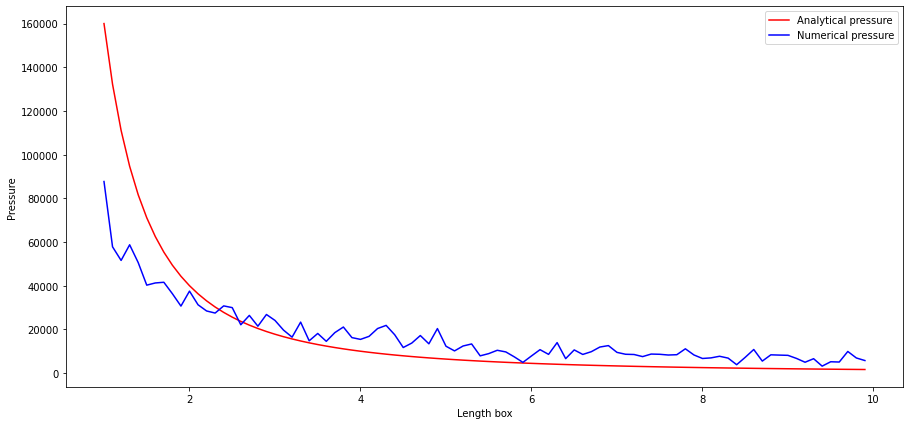

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(Ls,Panals, color="red", label ="Analytical pressure")    
plt.plot(Ls,Pnums*5e4, color="blue", label ="Numerical pressure")

plt.xlabel("Length box")
plt.ylabel("Pressure")
# plt.yscale("log")
plt.legend()
plt.show()

General trend of numerical pressure seems to be approximately similar to analytic except for a constant offset. We can do more Monte-Carlo-iterations for a smoother result.

### Animation

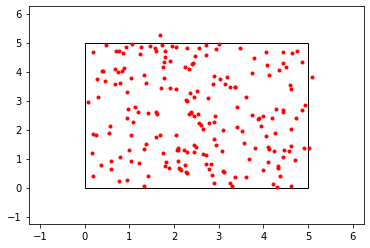

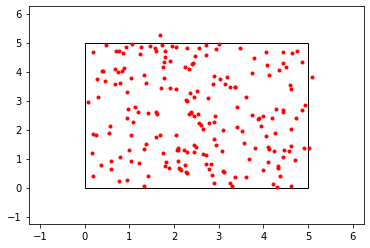

In [ ]:
L = 5
Vw = wallPot
V = nullPot
T = 273
No_parts = 200 # number of particles
No_montec = 400 # number of monte carlo iterations
K = 1e-3
a = 0.1
strength = 1.0
T = 273.

rs = initialPos(No_parts, L)
# Set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-L/4, 5/4*L), ylim=(-L/4, 5/4*L))
d, = ax.plot([r for r in rs[0]],
             [r for r in rs[1]], 'ro', markersize=3)
rect = patches.Rectangle((0, 0), L, L, linewidth=1, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
# animation function.  This is called sequentially
def animate(i,rs):
    rs_new = monteCarloBrrr(rs, L=L, K=K, a=a, T=T, No_montec=No_montec)
    d.set_data([r for r in rs_new[0,:]],
               [r for r in rs_new[1,:]])
    return rs_new

for i in range(0, No_montec, 10):
    rs = animate(i, rs)
    clear_output(wait=True)
    display(fig)
plt.show()

Particles are moving around like they should, not drifting off too far, but moving into the walls a little bit.

### 1b) Van der Waals gas law and hardcore particle potential
Same as with 1a) but using volume reduction for particles.

In [ ]:
# General pressure
@njit
def pressureVDW(No_parts, T, L, kB, a=1., b=0.5):
    return (No_parts * kB*T)/((L**2)-a)

In [ ]:
Ls, VDWanals, VDWnums = pressureOfArea(wallPot, hardcorePot, pressureVDW, T=320.)

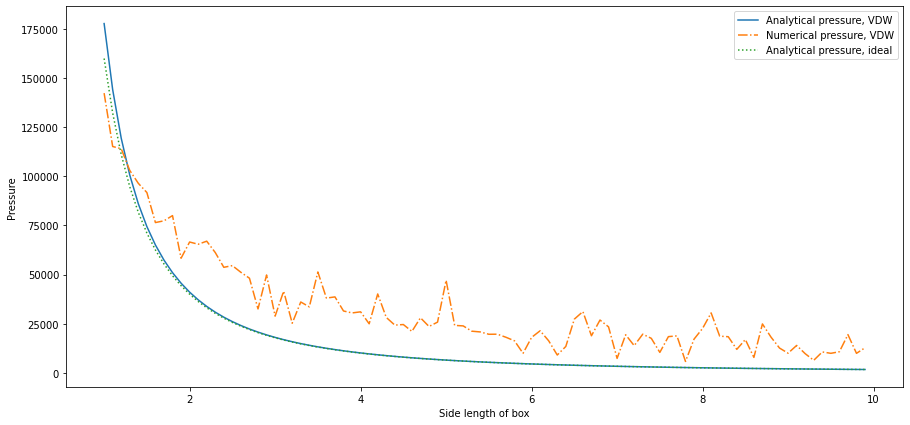

In [ ]:
plt.figure(figsize=(15,7))

plt.plot(Ls,VDWanals, linestyle="-", label ="Analytical pressure, VDW")    
plt.plot(Ls,VDWnums*1e5, linestyle="-.", label ="Numerical pressure, VDW")
plt.plot(Ls,Panals, linestyle=":", label ="Analytical pressure, ideal")

plt.xlabel("Side length of box")
plt.ylabel("Pressure")    
# plt.yscale("log")
plt.legend()
plt.show()

# c) - Lennard Jones potential

In [ ]:
def LJManGoneWild(Vw, V):

    strength = 1.0

    step = 0.5
    Ts = np.arange(step,5+step,step)
    Pnums = []
    Lss = []
    for i in range(np.shape(Ts)[0]-1):
        Ls, Panals_, Pnum = pressureOfArea(wallPot, LJPot, pressureIdeal, T=Ts[i], strength=strength)
        Pnums.append(Pnum)
        Lss.append(Ls)
    
    return Ts, Lss, Pnums

In [ ]:
Ts, Lss, Pnums = LJManGoneWild(wallPot, LJPot)

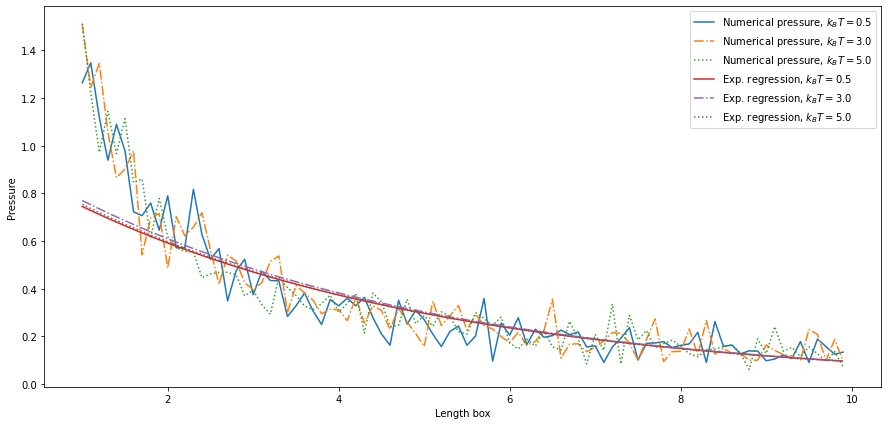

In [ ]:
plt.figure(figsize=(15,7))

L_smooth = np.arange(Lss[0][0], Lss[0][-1], 0.01)

reg1 = np.polyfit(Lss[0], np.log(Pnums[0]), deg = 1)
reg2 = np.polyfit(Lss[5], np.log(Pnums[5]), deg = 1)
reg3 = np.polyfit(Lss[-1], np.log(Pnums[-1]), deg = 1)

res1 = reg1[0]*L_smooth + reg1[1]
res2 = reg2[0]*L_smooth + reg2[1]
res3 = reg3[0]*L_smooth + reg3[1]


plt.plot(Lss[0],Pnums[0], linestyle="-", label =f"Numerical pressure, $k_BT={Ts[0]}$")
plt.plot(Lss[5],Pnums[5], linestyle="-.", label =f"Numerical pressure, $k_BT={Ts[5]}$")
plt.plot(Lss[-1],Pnums[-1], linestyle=":", label =f"Numerical pressure, $k_BT={Ts[-1]}$")

plt.plot(L_smooth,np.exp(res1), linestyle="-", label =f"Exp. regression, $k_BT={Ts[0]}$")
plt.plot(L_smooth,np.exp(res2), linestyle="-.", label =f"Exp. regression, $k_BT={Ts[5]}$")
plt.plot(L_smooth,np.exp(res3), linestyle=":", label =f"Exp. regression, $k_BT={Ts[-1]}$")

plt.xlabel("Length box")
plt.ylabel("Pressure")    
# plt.yscale("log")

plt.legend()
plt.show()

Hard to see any difference here. I think we need larger differences in temperature to distinguish between the systems. But can sort of see that higher temperatures give higher pressures, as expected

# d) - numerical pressure as a function of temperature

In [ ]:
@njit
def averageNumPressureAndPot(rs, L, K, a, T, Vw, V, strength=1000, No_micros=100, No_montec=100):

    avgPressure = 0
    avgPot = 0
    
    for i in range(No_micros):
        rs_new = monteCarloBrrr(rs, Vw = Vw, V=V, L = L, K = K, strength=strength, a=a, T=T, No_montec=No_montec)
        avgPressure += pressureWall(rs_new, L, K)
        for j in range(np.shape(rs_new)[1]-1):
            for k in range(j+1, np.shape(rs_new)[1]-1):
                dist = ( (rs_new[0,j]-rs_new[0,k])**2 + (rs_new[1,j]-rs_new[1,k])**2 )**(1/2)
                avgPot += LJPot(dist, a, strength)

    return avgPressure/No_micros, avgPot/No_micros

@njit
def LJfixarea():
    No_micros = 20 # number of microstates to evaluate
    No_parts = 400 # number of particles
    No_montec = 1000 # number of monte carlo iterations
    K = 0.01
    a = 0.1
    b = a*0.1
    strength = 1
    L = 5.0
    kB = 1

    step = 1e-10
    Ts = np.arange(0+step,101*step,step)
    pots = np.zeros_like(Ts,dtype=np.float64)
    Pnums = np.empty_like(Ts,dtype=np.float64)
    for i in range(np.shape(Ts)[0]-1):
        rs = initialPos(No_parts, L)
        Pnums[i], pots[i] = averageNumPressureAndPot(rs, K=K, L=L, Vw = wallPot, V=LJPot, a=a, T=Ts[i], strength=strength, No_micros=No_micros, No_montec=No_montec)
    
    return Ts, pots, Pnums

In [ ]:
Ts, pots, Pnums = LJfixarea()

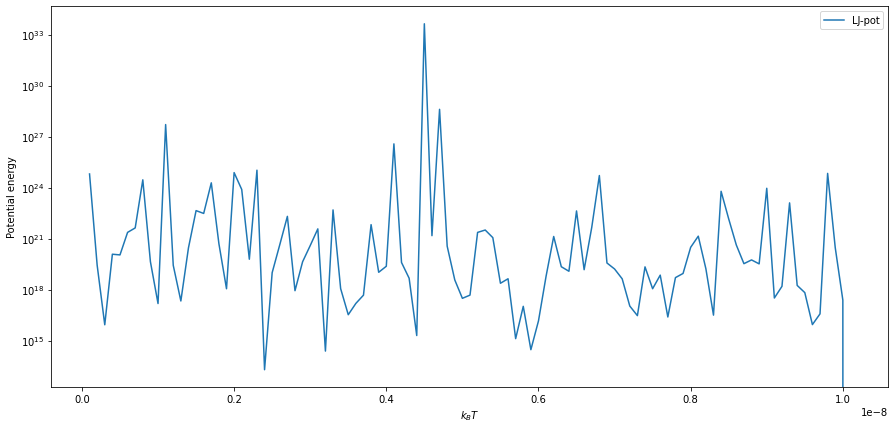

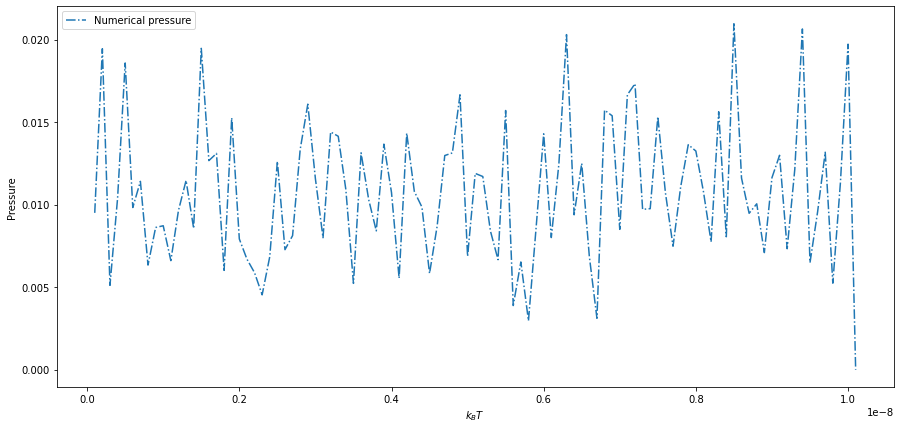

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(Ts,pots, linestyle="-", label =f"LJ-pot")
plt.xlabel(r"$k_B T$")
plt.ylabel("Potential energy")    
plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(15,7))
plt.plot(Ts,Pnums, linestyle="-.", label =f"Numerical pressure")
plt.xlabel(r"$k_B T$")
plt.ylabel("Pressure")    
plt.legend()
plt.show()


## Conclusion

We had alot of problems getting sensible results in this project, and therefore alot of time went into slightly changing parameters to make the systems work, which seemed like inefficient use of time. In the end we got some of the results which the task describes, but we don't feel we've actually learned anything after the initial implementation of the system. We do, however, see the trends in pressure vs. area as expected, but haven't gotten the temperature dependent system to work properly. Thus we cannot conclude with phase transisition and such, even though it we be a nice result to get.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=109fd87d-3853-4083-ad7c-5492d69ddc7d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>